In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.decomposition import PCA
from sklearn.processing import StandardScaler

In [50]:
# Edit options (optional)
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

In [84]:
# == Functions ==

# - Plotting

def plot_correlation_heatmap(data: pd.DataFrame, columns: list):
    """
    Plot correlation heatmap of specific columns
    """
    correlation_matrix = data[columns].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidth=0.5)
    plt.title("Correlation Heatmap for selected attributes")
    plt.show()

def plot_distributions(data: pd.DataFrame):
    """
    Plot distributions of numeric data
    """
    sns.set_style("whitegrid", {"grid_linestyle": "--"})
    # For each column plot their distribution
    # I need a max column grid
    columns = data.columns
    num_plots = len(columns)
    num_rows = math.ceil(num_plots / 2)
    num_columns = 2

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 12))
    axes = axes.ravel()
    for i, column in enumerate(columns):
        sns.histplot(data[column], ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {column}')
        axes[i].set_xlabel(column)
        plt.xlim(0)

    if num_plots % 2 != 0:
        axes.flat[-1].set_visible(False)
   
    plt.tight_layout()
    plt.show()

def plot_violin(data: pd.DataFrame, column: str):
    """
    Plot violin 
    """    
    plt.figure(figsize=(6, 6))
    sns.violinplot(y=column, data=data, orient="v")
    plt.title(f"Violin Plot of {column}")
    
    plt.show()

# - PCA Analysis

def plot_PCA_variance(numbers: list, ratios: list):
    """
    Plot variance ratio
    """
    plt.grid(True)
    plt.plot(numbers, ratios, marker="o")
    plt.xlabel("n_components")
    plt.ylabel("Explained Variance Ratio")
    plt.title("n_components vs. Explained Variance Ratio")
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.show()

# ====

In [52]:
dataset_path = "dataset/dataset-spotify-2023.csv"
data = pd.read_csv(dataset_path, encoding="latin-1")

In [53]:

# Rename selected columns
columns = ["danceability_%", "valence_%", "energy_%", "acousticness_%", "instrumentalness_%",
"liveness_%", "speechiness_%"]
data = data.rename(columns={column: column.replace("_%", "") for column in columns})

In [54]:
# Print nan count of `key` (95), no other column has missing data
key_None_count = data["key"].isna().sum()
in_shazam_charts_None_count = data["in_shazam_charts"].isna().sum()

print("`key` None count: ", key_None_count)
print("`in_shazam_charts` None count: ", in_shazam_charts_None_count)

# Replace NaN values with Unspecified, it may be useful later on
data = data.replace(np.nan, "Unavailable")

`key` None count:  95
`in_shazam_charts` None count:  50


In [55]:
# Data is malformed, need to remove comma `,`
data["in_deezer_playlists"] = data["in_deezer_playlists"].replace(",", "", regex=True)
data["in_shazam_charts"] = data["in_deezer_playlists"].replace(",", "", regex=True)

# Convert columns to int64
# streams, in_deezer_playlists, in_shazam_charts
data["in_deezer_playlists"] = data["in_deezer_playlists"].astype(int)
data["in_shazam_charts"] = data["in_shazam_charts"].astype(int)

# Streams overflowed with int, so use np.int64 to fit the whole numbers
data["streams"] = data["streams"].astype(np.int64)

# Wee see that `streams` is very large compared to to other data, next larger is `in_spotify_playlists`
# Add extra column with log value of streams
data["streams_log"] = np.log2(data["streams"])

In [56]:
# Problematic record 576 removed manually
# Love Grows (Where My Rosemary Goes),Edison Lighthouse,1,1970,1,1,2877,0,,16,0,54,0,0,110,A,Major,53,75,69,7,0,17,3

# Print statistics, print them without the scientific notation
print("Statistics", data.describe().apply(lambda s: s.apply(lambda x: format(x, "g"))).transpose())

# Print unique values of mode
# print(data["mode"].value_counts())
# print("Index of mistake in data:", data.index[data["mode"] == "53"].tolist())

Statistics                      count         mean          std      min          25%   
artist_count           952      1.55672     0.893331        1            1  \
released_year          952      2018.29      11.0114     1930         2020   
released_month         952      6.03887      3.56457        1            3   
released_day           952      13.9443      9.19722        1            6   
in_spotify_playlists   952      5202.57       7901.4       31        874.5   
in_spotify_charts      952      12.0221      19.5824        0            0   
streams                952  5.14137e+08  5.66857e+08     2762  1.41636e+08   
in_apple_playlists     952      67.8666      86.4706        0           13   
in_apple_charts        952      51.9632      50.6289        0            7   
in_deezer_playlists    952      385.536      1131.08        0           13   
in_deezer_charts       952      2.66912      6.03815        0            0   
in_shazam_charts       952      385.536      1131.08 

In [57]:
# One-hot encoding values
# Do not add, trouble with PCAs
# data = pd.get_dummies(data, columns=["key", "mode"], prefix=["key", "mode"])

In [77]:
# Select numeric columns
data_numeric = data.select_dtypes(exclude="object")
data_numeric.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   artist_count          952 non-null    int64  
 1   released_year         952 non-null    int64  
 2   released_month        952 non-null    int64  
 3   released_day          952 non-null    int64  
 4   in_spotify_playlists  952 non-null    int64  
 5   in_spotify_charts     952 non-null    int64  
 6   streams               952 non-null    int64  
 7   in_apple_playlists    952 non-null    int64  
 8   in_apple_charts       952 non-null    int64  
 9   in_deezer_playlists   952 non-null    int64  
 10  in_deezer_charts      952 non-null    int64  
 11  in_shazam_charts      952 non-null    int64  
 12  bpm                   952 non-null    int64  
 13  danceability          952 non-null    int64  
 14  valence               952 non-null    int64  
 15  energy                9

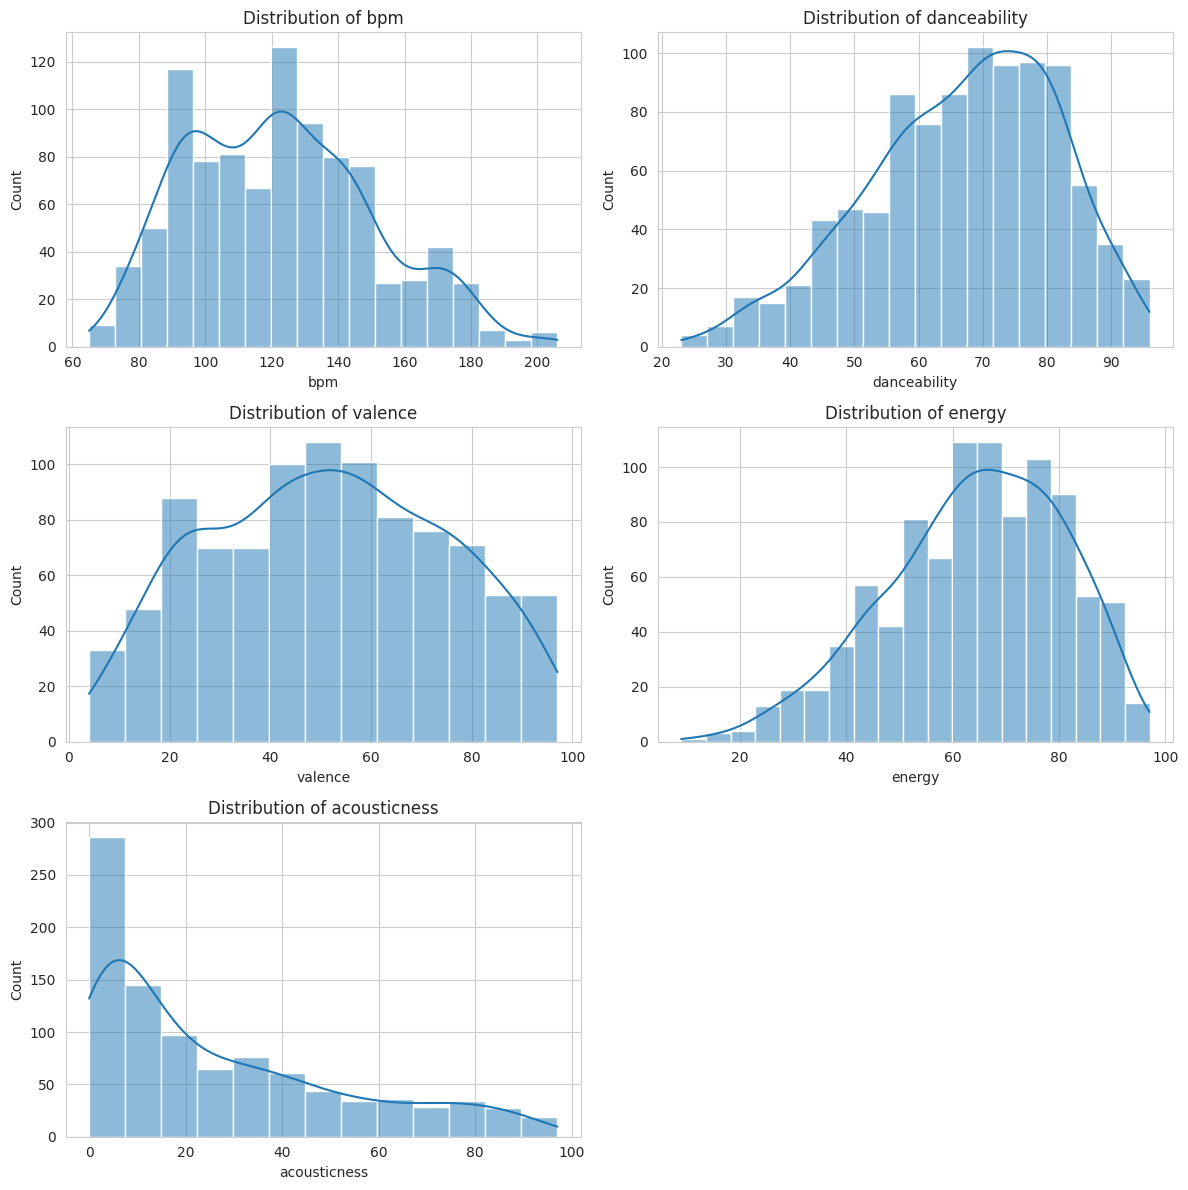

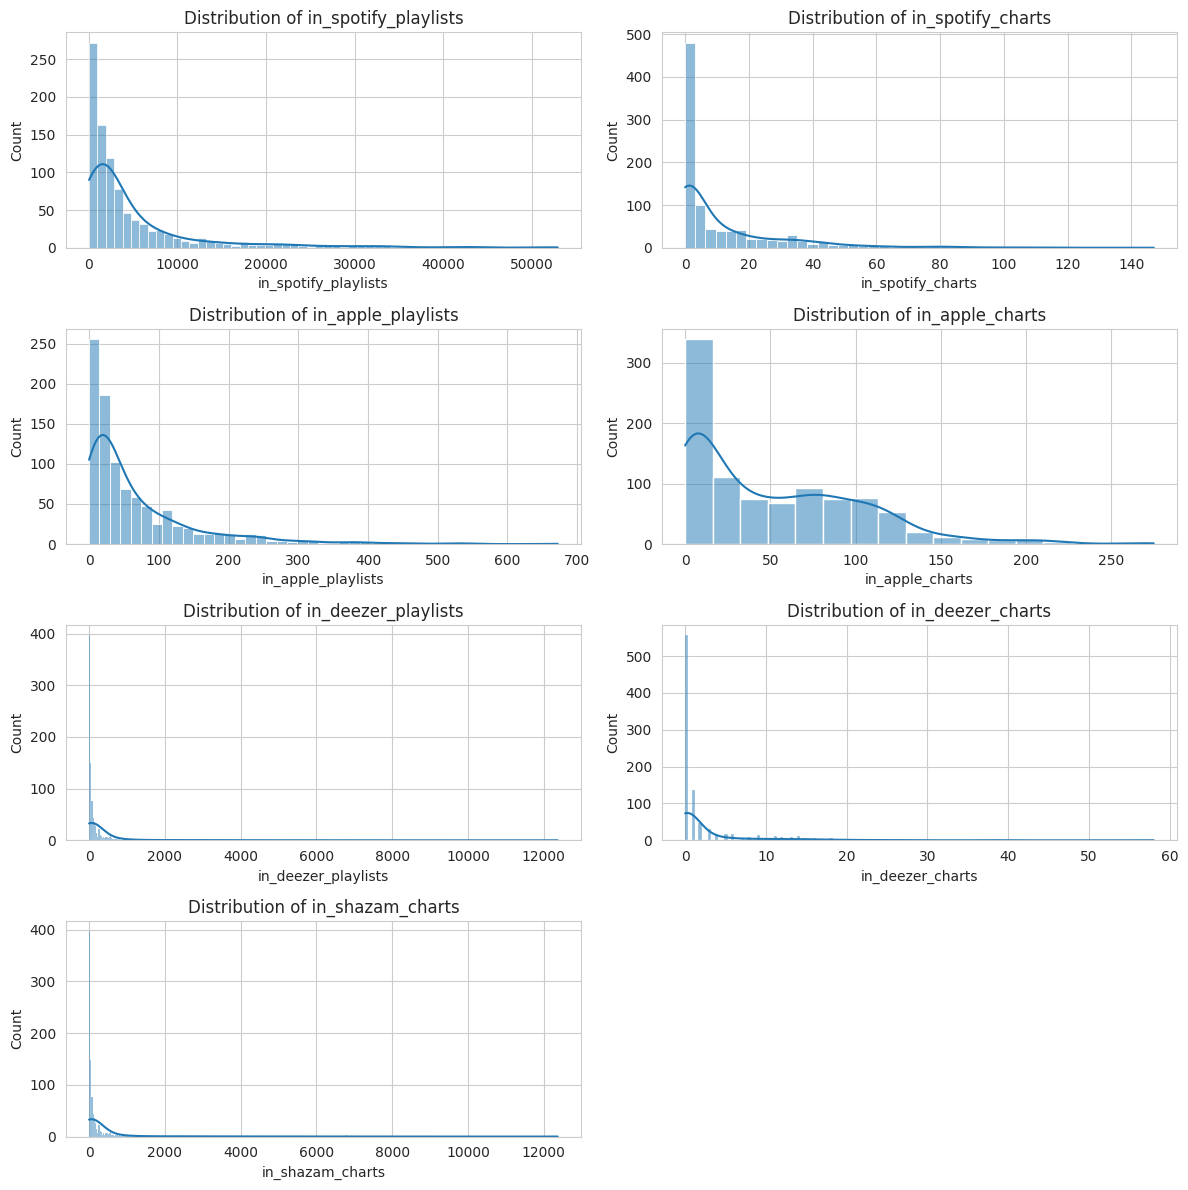

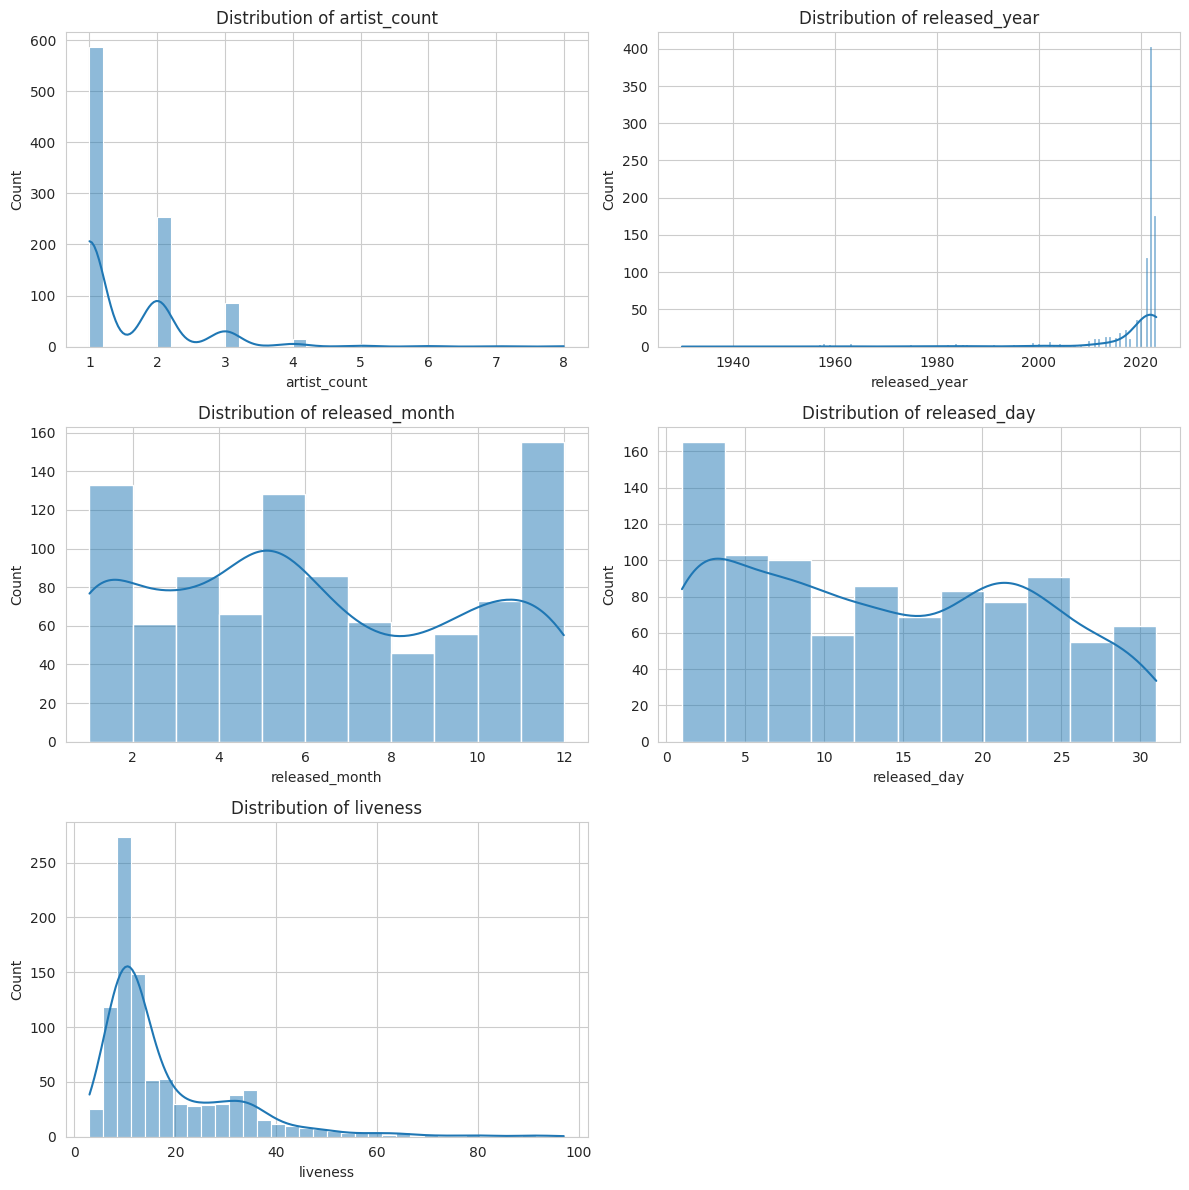

In [85]:
# Plot distribution of numeric datas
plot_distributions(data=data_numeric.iloc[:, 12:17])
plot_distributions(data=data_numeric.iloc[:, [4, 5, 7, 8, 9, 10, 11]])
plot_distributions(data=data_numeric.iloc[:, [0, 1, 2, 3, 18]])

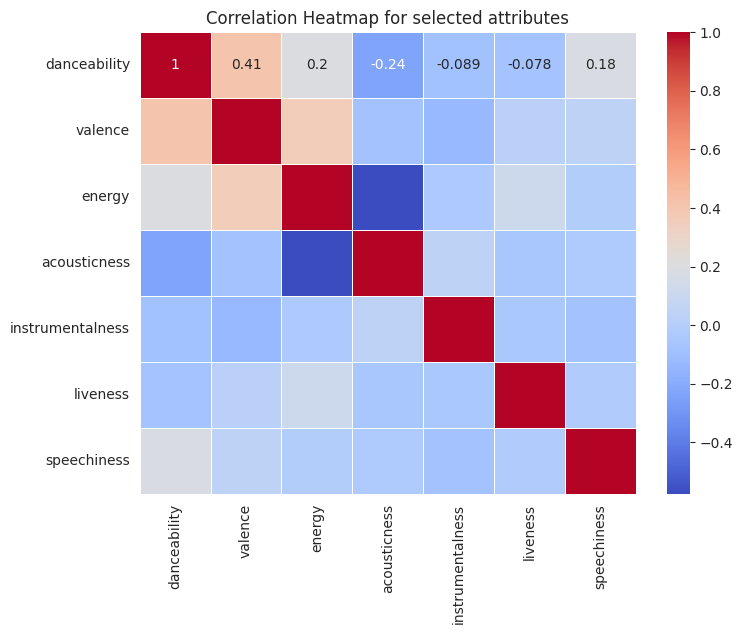

In [60]:
# Plot heatmap
plot_correlation_heatmap(data=data, columns = ["danceability", "valence", "energy", "acousticness", "instrumentalness",
"liveness", "speechiness"])

Number of components	0	total variance	0
Number of components	5	total variance	0.5440307422046436
Number of components	10	total variance	0.7804784639532849
Number of components	15	total variance	0.9420255634260882
Number of components	20	total variance	0.9999999999999999


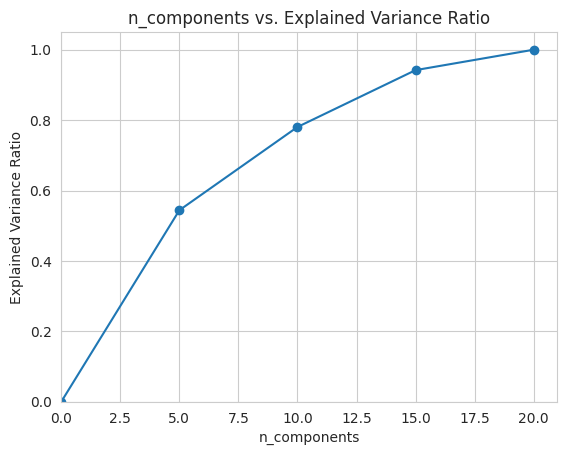

In [83]:
# PCA Analysis
# Number of PCA's and variance captured
data_scaled = StandardScaler().fit_transform(data_numeric)
variance_ratios = []
numbers = range(0, len(data_numeric.columns), 5)
for number in numbers:
    pca = PCA(n_components=number)
    pca.fit_transform(data_scaled)
    variance_ratios.append(np.sum(pca.explained_variance_ratio_))
    print(f"Number of components\t{number}\ttotal variance\t{sum(pca.explained_variance_ratio_)}")

plot_PCA_variance(numbers=numbers, ratios=variance_ratios)

In [62]:
# Principal direction of the PCA components

In [63]:
# Data projected into the PCA components

In [64]:
from scipy.stats import kstest
from scipy.stats import lognorm

In [65]:
# TODO: Kolmogorov Smirnov Test or other parametric test to see if values follow a normal distribution

In [66]:
# TODO: Handling outliers

## Characterizing data columns

* track_name    (discrete, nominal) 
* artist(s)_name    (discrete, nominal) 
* artist_count  (discrete, ratio) 
* released_year (discrete, ordinal) 
* released_month    (discrete, ordinal) 
* released_day  (discrete, ordinal) 
* in_spotify_playlists  (discrete, ratio) 
* in_spotify_charts (discrete, ratio) 
* streams   (discrete, ratio) 
* in_apple_playlists    (discrete, ratio)
* in_apple_charts   (discrete, ratio) 
* in_deezer_playlists   (discrete, ratio) 
* in_deezer_charts  (discrete, ratio)
* in_shazam_charts  (discrete, ratio) 
* bpm   (continuous, ratio) 
* key   (discrete, nominal) 
* mode  (discrete, nominal) 
* danceability_%    (continuous, ratio) 
* valence_% (continuous, ratio) 
* energy_%  (continuous, ratio) 
* acousticness_%    (continuous, ratio) 
* instrumentalness_%    (continuous, ratio) 
* liveness_%    (continuous, ratio) 
* speechiness_% (continuous, ratio) 

## Useful code from Toolbox

There is a list of already implemented functions we can use from the ToolBox to perform Data Analysis.

* categoric2numeric.py : one-hot encoding
* similarity.py : similarity matrices
* statistics.py : chi-squared tests and other
* ex1_5_4.py : regression problem plot
* ex2_1_2.py : scatterplot
* ex2_1_3.py : PCAs
* ...
